In [1]:
# importing libraries and functions
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read

In [2]:
# ground truth values
ground_truth_formants = np.array([300, 870, 2240])

# reading the two sound files generated from previous assignment using scipy.io.wavfile.write function
rate, u120 = read("u-120.wav")
_, u220 = read("u-220.wav")

# an array containg the time duration of the windows
t_ms = np.array([5, 10, 20, 40])
# an array containing the number of samples (window length) required for different window time durations
obs = t_ms*rate//1000
# the starting index since we need to sample the audio waveform from the middle of the signal where it is homogeneous and not from the beginning
idx = 1000
# dictionaries to store the waveform segments
rect = {120:[], 220:[]}
hamming = {120:[], 220:[]}

for i in range(len(obs)):
    # rect window is simply taking the samples inside the window as they are
    rect[120].append(u120[idx:idx+obs[i]])
    rect[220].append(u220[idx:idx+obs[i]])
    # hamming window is applied to the waveform segments before storing
    hamming[120].append(np.hamming(obs[i]) * rect[120][i])
    hamming[220].append(np.hamming(obs[i]) * rect[220][i])

# size of DFT
size = 1024
# the frequency axis points where the samples of the DFT would lie
f = np.fft.rfftfreq(size, 1/rate)
# dictionary to store the magnitude values
mag = {'rect_120':[], 'rect_220':[], 'hamming_120':[], 'hamming_220':[]}

for i in range(len(obs)):
    # computing and storing the magnitude of the DFT in dB
    mag['rect_120'].append(20*np.log10(abs(np.fft.rfft(rect[120][i], n=size))))
    mag['rect_220'].append(20*np.log10(abs(np.fft.rfft(rect[220][i], n=size))))
    mag['hamming_120'].append(20*np.log10(abs(np.fft.rfft(hamming[120][i], n=size))))
    mag['hamming_220'].append(20*np.log10(abs(np.fft.rfft(hamming[220][i], n=size))))

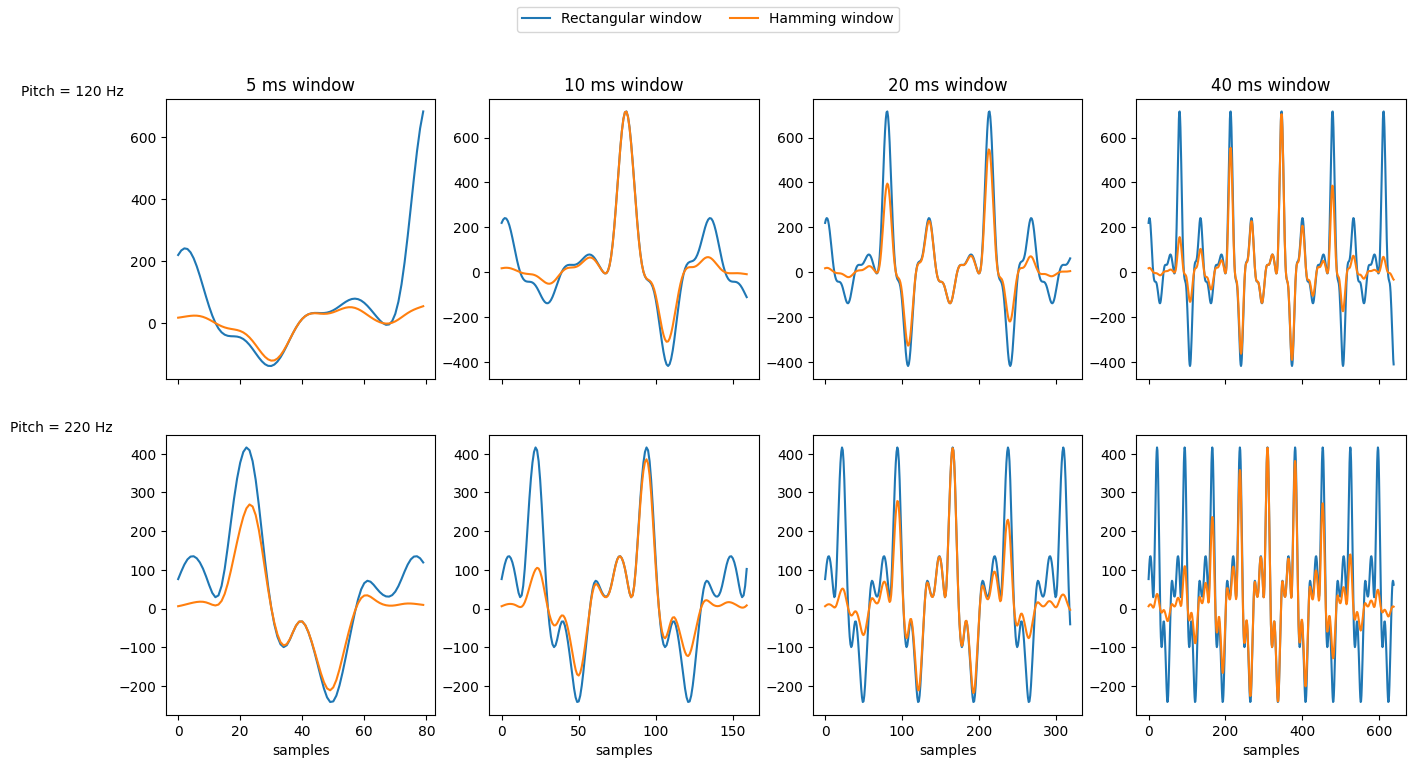

In [3]:
# plotting the various audio waveform segments after applying the different windows
fig, ax = plt.subplots(nrows=2, ncols=4, sharex='col', figsize=(16, 8))
ax[0, 0].set_ylabel("Pitch = 120 Hz", rotation=0, loc='top')
ax[1, 0].set_ylabel("Pitch = 220 Hz", rotation=0, loc='top')
for i in range(len(obs)):
    ax[0, i].set_title(f"{t_ms[i]} ms window")
    ax[-1, i].set_xlabel("samples")
    ax[0, i].plot(rect[120][i])
    ax[0, i].plot(hamming[120][i])
    ax[1, i].plot(rect[220][i])
    ax[1, i].plot(hamming[220][i])
fig.legend(["Rectangular window", "Hamming window"], loc='upper center', ncols=2)
plt.show()

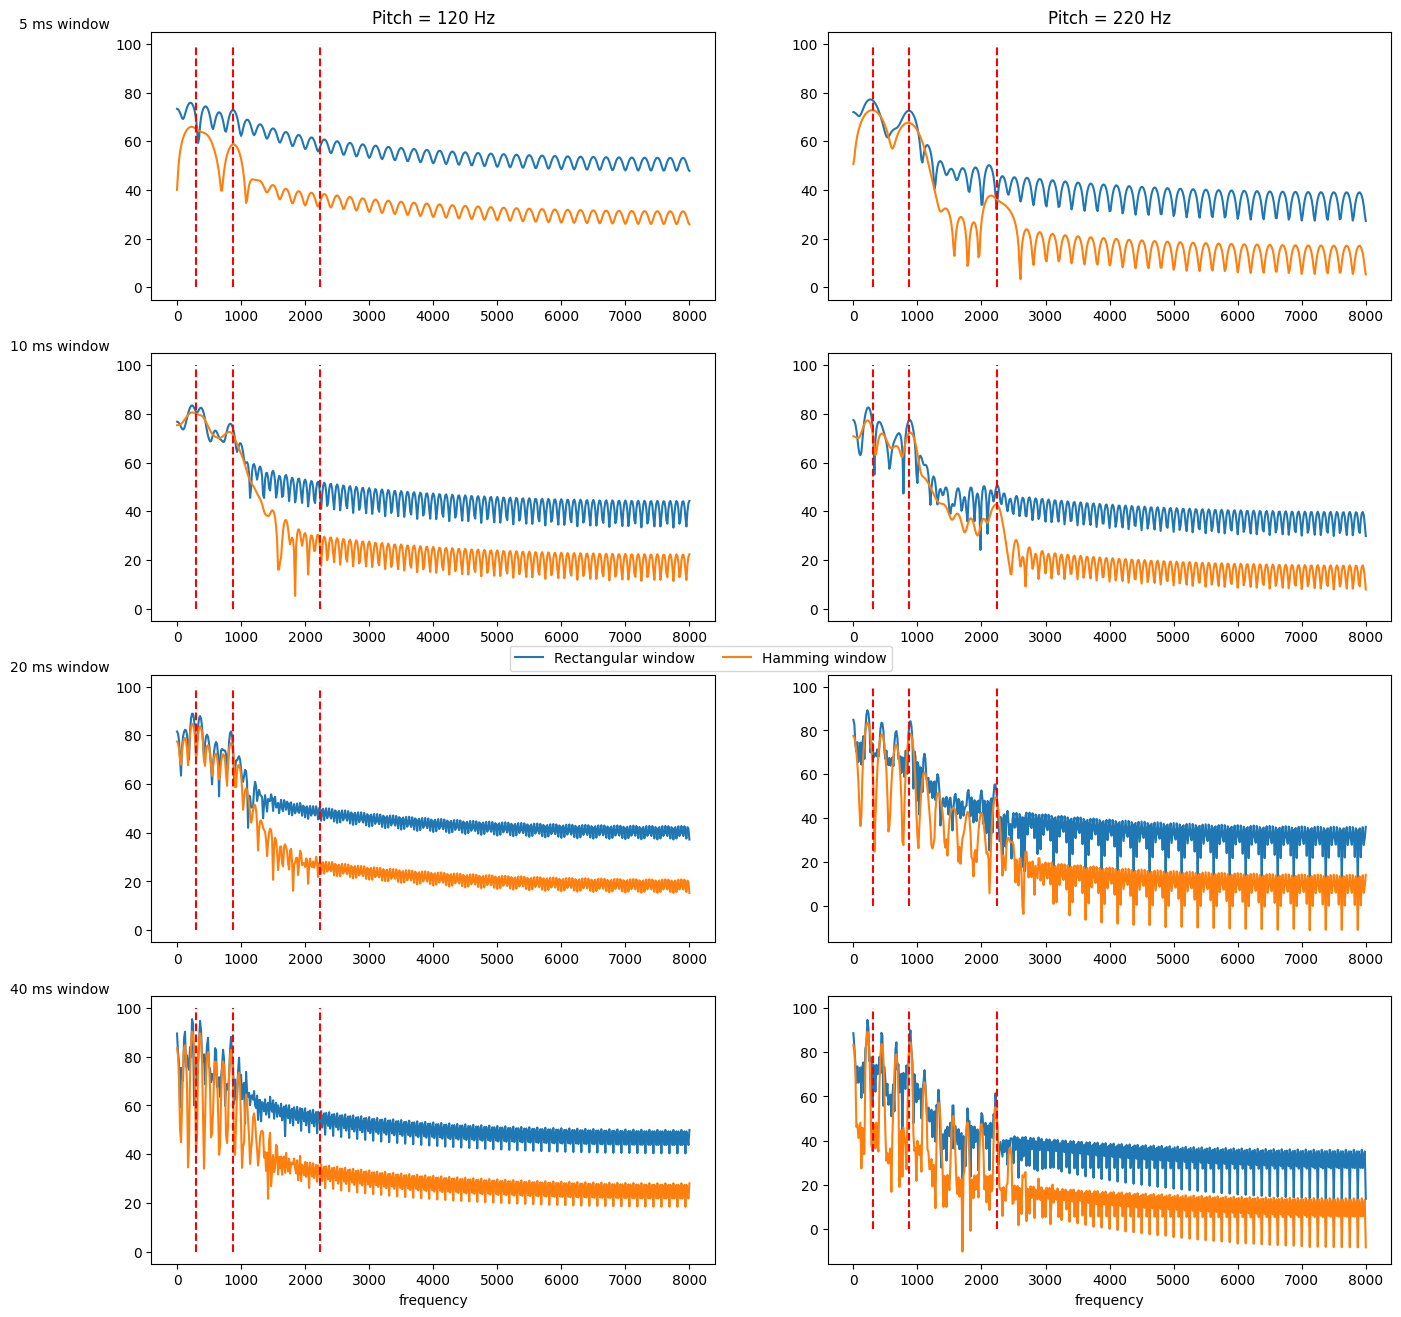

In [4]:
# plotting the magnitude responses along with the ground truth formants
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(16, 16))
ax[0, 0].set_title("Pitch = 120 Hz")
ax[0, 1].set_title("Pitch = 220 Hz")
ax[-1, 0].set_xlabel("frequency")
ax[-1, 1].set_xlabel("frequency")
keys = list(mag.keys())
for i in range(len(obs)):
    ax[i, 0].set_ylabel(f"{t_ms[i]} ms window", rotation=0,loc='top')
    ax[i, 0].plot(f, mag[keys[0]][i])
    ax[i, 1].plot(f, mag[keys[1]][i])
    ax[i, 0].plot(f, mag[keys[2]][i])
    ax[i, 1].plot(f, mag[keys[3]][i])
    [[ax[i, j].plot([F]*2, [0, 100], c='r', linestyle='dashed') for F in ground_truth_formants] for j in range(2)]
fig.legend(["Rectangular window", "Hamming window"], loc='center', ncols=2)
plt.show()

<h1>Observations</h1>

As discussed in class, we can only identify the formants, when they are sampled. Above we can see that the first and third formants are not always sampled, whereas the second formant is always sampled and thus we can determine it correctly (with less error form the ground truth value).

The high frequency region for the larger window sizes has a lot of oscillations, compared to the high frequency region of the smaller window sizes.

As the pitch (fundamental frequency) changes from the left to the right, we can clearly see how the seperation between the peaks increases.

Varying the window shape as shown with a different color in the same plot, we can not only see the slight smoothing effect but we also notice that the magnitude drops 
significantly quickly as the frequency increases.

In [5]:
# function to computationally estimate the pitch (fundamentla frequency) and the formants from the DFT magnitude
def get_pitch_formants(window, frequency, t):
    m = mag[f'{window}_{frequency}'][t]

    mag_peak_indices_values = [[i+np.argmax(m[i:i+11]), max(m[i:i+11])] for i in range(m.shape[0]-10)]

    unique_peak_indices_values = []
    for i in range(1, len(mag_peak_indices_values)):
        if mag_peak_indices_values[i] in unique_peak_indices_values:
            continue
        else:
            if mag_peak_indices_values[i][0] == mag_peak_indices_values[i-1][0]:
                unique_peak_indices_values.append(mag_peak_indices_values[i])

    unique_peak_indices_values.insert(0, [0, 0])
    freqs = np.array([f[i[0]] for i in unique_peak_indices_values if f[i[0]] < [3750, 1600][t//2]])
    freqs = freqs[1:] - freqs[:-1]
    pitch = np.median(freqs)
    
    formant_indices = []
    for i in range(1, len(unique_peak_indices_values)-1):
        if unique_peak_indices_values[i][1] == max([unique_peak_indices_values[j][1] for j in range(max(i-[1, 2][t//2], 0), min(i+[1, 2][t//2]+1, len(unique_peak_indices_values)))]):
            formant_indices.append(unique_peak_indices_values[i][0])
    formants = f[formant_indices]
    
    return pitch, formants[formants < 3000]

# using the function defined above to estimate the signal parameters
estimates = {}
for i in range(len(keys)):
    estimates[keys[i]] = {'pitch':[], 'formants':[]}
    for t in range(len(obs)):
        p, fr = get_pitch_formants(*keys[i].split("_"), t)
        estimates[keys[i]]['pitch'].append(p)
        if len(fr) != 3:
            frm = np.zeros(3)
            for j in range(len(fr)):
                frm[np.argmin(abs(ground_truth_formants-fr[j]))] = fr[j]
            fr = frm
        estimates[keys[i]]['formants'].append(fr)

# reporting all the estmates and errors
print("\t\t\t\t{} ms window\t|\t{} ms window\t|\t{} ms window\t|\t{} ms window".format(*t_ms))
for key in keys:
    if '120' in key:
        print("_"*120)
        print("Rectangular Window" if 'rect' in key else "Hamming window")
        print("="*120)
        print("Pitch = 120 Hz")
    else:
        print("-"*120)
        print("Pitch = 220 Hz")
    
    estimate_pitch = estimates[key]['pitch']
    for i in range(2):
        print("\t\t{}\t{}\t\t|\t{}\t\t|\t{}\t\t|\t{}".format(["Estimated", "Error\t"][i], *[estimate_pitch, [abs(j-int(key[-3:])) for j in estimate_pitch]][i]))

    print("-"*120)
    print("Formants = " + ', '.join([str(i) for i in ground_truth_formants]) + " Hz")
    
    estimate_formants = estimates[key]['formants']
    for i in range(2):
        print("\t\t{}".format(["Estimated", "Error\t"][i]))
        for j in range(3):
            print("\t\t\t\t{}\t\t|\t{}\t\t|\t{}\t\t|\t{}".format(*[[str(est[j])[:-1] if est[j] != 0 else "N.A." for est in estimate_formants], [err[j] for err in [[np.min(abs(k-ground_truth_formants)) if k != 0 else "N.A." for k in estimate_formants[l]] for l in range(4)]]][i]))

				5 ms window	|	10 ms window	|	20 ms window	|	40 ms window
________________________________________________________________________________________________________________________
Rectangular Window
Pitch = 120 Hz
		Estimated	203.125		|	109.375		|	125.0		|	125.0
		Error		83.125		|	10.625		|	5.0		|	5.0
------------------------------------------------------------------------------------------------------------------------
Formants = 300, 870, 2240 Hz
		Estimated
				203.12		|	234.37		|	234.37		|	234.37
				875.		|	828.12		|	843.7		|	843.7
				N.A.		|	N.A.		|	N.A.		|	N.A.
		Error	
				96.875		|	65.625		|	65.625		|	65.625
				5.0		|	41.875		|	26.25		|	26.25
				N.A.		|	N.A.		|	N.A.		|	N.A.
------------------------------------------------------------------------------------------------------------------------
Pitch = 220 Hz
		Estimated	203.125		|	109.375		|	203.125		|	187.5
		Error		16.875		|	110.625		|	16.875		|	32.5
-----------------------------------------------------------------------

The N.A. in the above table means that the function could not find out that partiular formant from the magnitude plot. Hence, the corresponding error has also been reported as N.A.